In [8]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import xgboost as xgb
from sklearn.metrics import log_loss
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [237]:
df = pd.read_csv("train.gz", compression='gzip', header='infer')
# test = pd.read_csv("test.gz", compression='gzip', header='infer')

In [18]:
df.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683787 entries, 0 to 2683786
Data columns (total 24 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   id                int64 
 1   click             int64 
 2   hour              int64 
 3   C1                int64 
 4   banner_pos        int64 
 5   site_id           object
 6   site_domain       object
 7   site_category     object
 8   app_id            object
 9   app_domain        object
 10  app_category      object
 11  device_id         object
 12  device_ip         object
 13  device_model      object
 14  device_type       int64 
 15  device_conn_type  int64 
 16  C14               int64 
 17  C15               int64 
 18  C16               int64 
 19  C17               int64 
 20  C18               int64 
 21  C19               int64 
 22  C20               int64 
 23  C21               int64 
dtypes: int64(15), object(9)
memory usage: 491.4+ MB


In [19]:
# target value
print("Imbalance ratio: {}".format(float(len(df[df['click']==0]))/len(df[df['click']==1])))
print("CTR is {}%".format(100.0*df['click'].sum()/len(df)))

Imbalance ratio: 3.94863265656087
CTR is 20.207602168130332%


In [20]:
# visualize levels for each categorical feature
for column in df:
    print(f"{column}: {df[str(column)].unique()}; number of levels: {df[str(column)].nunique()}")

id: [      1       2       3 ... 2683785 2683786 2683787]; number of levels: 2683787
click: [0 1]; number of levels: 2
hour: [14102100 14102101 14102102 14102103 14102104 14102105 14102106 14102107
 14102108 14102109 14102110 14102111 14102112 14102113 14102114 14102115
 14102116 14102117 14102118 14102119 14102120 14102121 14102122 14102123
 14102200 14102201]; number of levels: 26
C1: [ 5  2  1 10 12]; number of levels: 5
banner_pos: [0 1 4 2 3]; number of levels: 5
site_id: ['078d3465' 'a2af7bee' '41c76965' ... '247f8c46' 'a0a4523d' '3281baa7']; number of levels: 2892
site_domain: ['dd641cc7' 'cbee4b41' '0c2800f3' ... 'fe7806d9' '2f4fefe4' 'f92cc11f']; number of levels: 3446
site_category: ['8fd0aea4' '72722551' '74073276' '28905ebd' 'f66779e6' 'dedf689d'
 '9ccfa2ea' 'bcf865d9' '76b2941d' '110ab22d' '42a36e14' '70fb0e29'
 'c0dd3be3' '75fa27f6' '0569f928' '50e219e0' '335d28a8' '3e814130'
 'a818d37a' 'e787de0e' 'f028772b' '5378d028']; number of levels: 22
app_id: ['ecda2021']; number 

<h2> Feature Engineering + Data Preprocessing

In [238]:
# change all type to object since features are all categorical
#df = df.astype("category")

In [239]:
# handling time info: year and month same for all observations
# https://www.alpha-quantum.com/blog/ctr-prediction/ctr-prediction-using-hashing-trick-logistic-regression-sgd-and-only-simple-python/
df['hour']=df['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
df['day_of_week']=df['hour'].map(lambda x:  x.weekday()) # 1: tues, 2: wed
df['hour']=df['hour'].map(lambda x:  x.hour)

In [240]:
# drop categories that have only one level (same for all observations)
df.drop(['id','app_id', 'app_domain', 'app_category'], axis=1, inplace=True)

<h4> removing rare features

In [7]:
# removing rare features
site_id_rare = pd.DataFrame(df.groupby("site_id").size())
site_id_rare[0] = np.where(site_id_rare[0] == 1, "Unknown", site_id_rare[0])
rare_sites = site_id_rare[site_id_rare[0] == "Unknown"].index
df["site_id"] = np.where(df["site_id"].isin(rare_sites), "Unknown", df["site_id"])

In [8]:
site_domain_rare = pd.DataFrame(df.groupby("site_domain").size())
site_domain_rare[0] = np.where(site_domain_rare[0] == 1, "Unknown", site_domain_rare[0])
rare_sites = site_domain_rare[site_domain_rare[0] == "Unknown"].index
df["site_domain"] = np.where(df["site_domain"].isin(rare_sites), "Unknown", df["site_domain"])

In [9]:
device_id_rare = pd.DataFrame(df.groupby("device_id").size())
device_id_rare[0] = np.where(device_id_rare[0] == 1, "Unknown", device_id_rare[0])
rare_device = device_id_rare[device_id_rare[0] == "Unknown"].index
df["device_id"] = np.where(df["device_id"].isin(rare_device), "Unknown", df["device_id"])

In [10]:
device_ip_rare = pd.DataFrame(df.groupby("device_ip").size())
device_ip_rare[0] = np.where(device_ip_rare[0] == 1, "Unknown", device_ip_rare[0])
rare_device = device_ip_rare[device_ip_rare[0] == "Unknown"].index
df["device_ip"] = np.where(df["device_ip"].isin(rare_device), "Unknown", df["device_ip"])

In [11]:
device_model_rare = pd.DataFrame(df.groupby("device_model").size())
device_model_rare[0] = np.where(device_model_rare[0] == 1, "Unknown", device_model_rare[0])
rare_device = device_model_rare[device_model_rare[0] == "Unknown"].index
df["device_model"] = np.where(df["device_model"].isin(rare_device), "Unknown", df["device_model"])

In [12]:
c_rare = pd.DataFrame(df.groupby("C14").size())
c_rare[0] = np.where(c_rare[0] == 1, "Unknown", c_rare[0])
rare_c = c_rare[c_rare[0] == "Unknown"].index
df["C14"] = np.where(df["C14"].isin(rare_device), "Unknown", df["C14"])

In [13]:
c_rare = pd.DataFrame(df.groupby("C17").size())
c_rare[0] = np.where(c_rare[0] == 1, "Unknown", c_rare[0])
rare_c = c_rare[c_rare[0] == "Unknown"].index
df["C17"] = np.where(df["C17"].isin(rare_device), "Unknown", df["C17"])

In [14]:
c_rare = pd.DataFrame(df.groupby("C20").size())
c_rare[0] = np.where(c_rare[0] == 1, "Unknown", c_rare[0])
rare_c = c_rare[c_rare[0] == "Unknown"].index
df["C20"] = np.where(df["C20"].isin(rare_device), "Unknown", df["C20"])

In [15]:
user_rare = pd.DataFrame(df.groupby("user").size())
user_rare[0] = np.where(user_rare[0] == 1, "Unknown", user_rare[0])
rare_user = user_rare[user_rare[0] == "Unknown"].index
df["user"] = np.where(df["user"].isin(rare_user), "Unknown", df["user"])

In [5]:
df

,click,hour,C1,banner_pos,site_id,site_domain,site_category,device_id,device_ip,device_model,...,C19,C20,C21,day_of_week,device_ip_count,device_id_count,hour_count,user,hourly_user_count,click_history
0,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,ddd2926e,44956a24,...,3,-1,67,1,7647.0,2533255,140117,ddd2926e44956a24,4.0,first string
1,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,96809ac8,711ee120,...,3,85,67,1,7.0,2533255,140117,96809ac8711ee120,3.0,first string
2,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,b3cf8def,8a4875bd,...,3,85,67,1,2.0,2533255,140117,b3cf8def8a4875bd,2.0,first string
3,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,e8275b8f,6332421a,...,3,85,67,1,6.0,2533255,140117,e8275b8f6332421a,2.0,first string
4,0,0,5,1,a2af7bee,cbee4b41,72722551,a99f214a,9644d0bf,779d90c2,...,3,-1,145,1,31.0,2533255,140117,9644d0bf779d90c2,15.0,first string
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683782,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,8546df25,67fb3069,...,7,-1,145,2,NaN,2533255,147294,8546df2567fb3069,5.0,1110
2683783,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,98e4ada3,b314d7b9,...,131,-1,49,2,NaN,2533255,147294,98e4ada3b314d7b9,4.0,010
2683784,1,1,5,0,5bb07e04,b256a9bc,f66779e6,a99f214a,dc38aa07,76dc4769,...,135,-1,11,2,NaN,2533255,147294,dc38aa0776dc4769,1.0,first string
2683785,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,e5693fd8,7120e05e,...,7,-1,11,2,NaN,2533255,147294,e5693fd87120e05e,4.0,0000010


<h4> computing feature count

In [3]:
# compute features for device_ip_count, device_id_count, hourly_impression_count, hourly_user_count
device_ip_df = pd.DataFrame(df.groupby("device_ip").size())
device_id_df = pd.DataFrame(df.groupby("device_id").size())
hourly_impression_df = pd.DataFrame(df.groupby("hour").size())

In [17]:
df.drop(["device_ip_count", "device_id_count", "hour_count", "user", "hourly_user_count"], inplace=True, axis=1)

In [4]:
%%timeit
def get_count(device_ip):
    return device_ip_df.loc[device_ip][0]
    
df['device_ip_count'] = df['device_ip'].iloc[:100].apply(lambda x: get_count(x))

41.7 ms ± 651 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
def get_count(device_id):
    return device_id_df.loc[device_id][0]
    
df['device_id_count'] = df['device_id'].iloc[:100].apply(lambda x: get_count(x))

54.8 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def get_count(hour):
    return hourly_impression_df.loc[hour][0]
    
df['hour_count'] = df['hour'].apply(lambda x: get_count(x))

In [ ]:
def get_user(row):
    if str(row['device_id']) != "a99f214a":
        return row['device_id']
    else:
        device_ip = row["device_ip"]
        device_model = row["device_model"]
        return str(device_ip) + str(device_model)
    
df['user'] = df.apply(lambda row: get_user(row), axis=1)

In [ ]:
# get count for hourly user
hourly_user_df = pd.DataFrame(df.groupby(["hour", "user"]).size().unstack())

def get_count(row):
    hour = row['hour']
    user = row['user']
    
    desired = hourly_user_df.loc[hour, user]
    
    if desired == np.nan:
        return 0
    else:
        return desired
    
df['hourly_user_count'] = df.apply(lambda row: get_count(row), axis=1)

In [109]:
# create click history
now = time.time()

users_done = 0
sample['click'] = sample['click'].astype('str')
        
for user in sample['user'].unique():
    subset = sample[sample['user'].isin([user])]
    click_string = ''.join(subset['click'])
    
    subset['click_history'] = [click_string[:i-1] for i in range(1, len(click_string)+1)]
    
    df.loc[subset.index, 'click_history'] = subset['click_history']
    
    users_done += 1
    
    if np.random.randint(1, 1000) == 500:
        perc_users_complete = users_done / 515000
        time_elapsed = time.time() - now
        print(f'percentage of users complete: {perc_users_complete}')
        print(f'time elapsed: {time_elapsed / 60 / 60}h')

<ipython-input-109-ba89fa678dac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['click'] = sample['click'].astype('str')
<ipython-input-109-ba89fa678dac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['click_history'] = [click_string[:i-1] for i in range(1, len(click_string)+1)]


percentage of users complete: 0.0005786407766990292
time elapsed: 0.012523253162701925h
percentage of users complete: 0.00230873786407767
time elapsed: 0.04809508184591929h
percentage of users complete: 0.005780582524271845
time elapsed: 0.11809839407602946h
percentage of users complete: 0.00710873786407767
time elapsed: 0.1433219971921709h
percentage of users complete: 0.007128155339805826
time elapsed: 0.1437078032228682h
percentage of users complete: 0.007594174757281553
time elapsed: 0.1529076933198505h
percentage of users complete: 0.01243883495145631
time elapsed: 0.24883458468649122h
percentage of users complete: 0.014576699029126214
time elapsed: 0.28870249019728766h
percentage of users complete: 0.015153398058252427
time elapsed: 0.2996321778164969h
percentage of users complete: 0.01606990291262136
time elapsed: 0.31669353750016954h
percentage of users complete: 0.016821359223300972
time elapsed: 0.33332459840509626h
percentage of users complete: 0.01789514563106796
time elaps

percentage of users complete: 0.18104660194174757
time elapsed: 3.3397753405570985h
percentage of users complete: 0.18251456310679612
time elapsed: 3.3665725233157473h
percentage of users complete: 0.18266601941747573
time elapsed: 3.3693021286858453h
percentage of users complete: 0.18643106796116504
time elapsed: 3.437154114908642h
percentage of users complete: 0.18731456310679612
time elapsed: 3.4530947791867783h
percentage of users complete: 0.1897864077669903
time elapsed: 3.4977324331469006h
percentage of users complete: 0.19408543689320387
time elapsed: 3.5769235130813386h
percentage of users complete: 0.19653009708737865
time elapsed: 3.6213622068034277h
percentage of users complete: 0.19766990291262135
time elapsed: 3.6422223909695943h
percentage of users complete: 0.1982368932038835
time elapsed: 3.652434443698989h
percentage of users complete: 0.19893592233009708
time elapsed: 3.665341142813365h
percentage of users complete: 0.1996135922330097
time elapsed: 3.6775201342503228

percentage of users complete: 0.3321572815533981
time elapsed: 6.134405235449473h
percentage of users complete: 0.3322155339805825
time elapsed: 6.135514136287901h
percentage of users complete: 0.33343106796116506
time elapsed: 6.158106115526623h
percentage of users complete: 0.3342873786407767
time elapsed: 6.174287858340476h
percentage of users complete: 0.3353339805825243
time elapsed: 6.193942391342587h
percentage of users complete: 0.3367553398058252
time elapsed: 6.220344352655941h
percentage of users complete: 0.33716893203883497
time elapsed: 6.228291179007954h
percentage of users complete: 0.34288155339805826
time elapsed: 6.336897910700904h
percentage of users complete: 0.34392038834951455
time elapsed: 6.356293358074295h
percentage of users complete: 0.3468699029126214
time elapsed: 6.411356628537178h
percentage of users complete: 0.34742912621359223
time elapsed: 6.422131214737892h
percentage of users complete: 0.3477902912621359
time elapsed: 6.42925336751673h
percentage o

percentage of users complete: 0.5028757281553398
time elapsed: 9.473175902896458h
percentage of users complete: 0.5072970873786408
time elapsed: 9.575488818950124h
percentage of users complete: 0.509926213592233
time elapsed: 9.630533606542482h
percentage of users complete: 0.5140485436893204
time elapsed: 9.71494205362267h
percentage of users complete: 0.5151650485436893
time elapsed: 9.737336962355506h
percentage of users complete: 0.5159165048543689
time elapsed: 9.752041391332943h
percentage of users complete: 0.5166368932038835
time elapsed: 9.76654064046012h
percentage of users complete: 0.5232271844660195
time elapsed: 9.927418491840363h
percentage of users complete: 0.523421359223301
time elapsed: 9.931247746944427h
percentage of users complete: 0.5252854368932038
time elapsed: 9.969515568216643h
percentage of users complete: 0.5254990291262136
time elapsed: 9.97375923468007h
percentage of users complete: 0.5256504854368932
time elapsed: 9.976785092684958h
percentage of users c

percentage of users complete: 0.6961359223300971
time elapsed: 13.38440454741319h
percentage of users complete: 0.6963650485436893
time elapsed: 13.388936921026973h
percentage of users complete: 0.6980699029126214
time elapsed: 13.422862262858285h
percentage of users complete: 0.6985300970873787
time elapsed: 13.432283419569334h
percentage of users complete: 0.6994621359223301
time elapsed: 13.451529167956776h
percentage of users complete: 0.7011592233009709
time elapsed: 13.487237497501903h
percentage of users complete: 0.701673786407767
time elapsed: 13.497788469195367h
percentage of users complete: 0.7060932038834952
time elapsed: 13.587109572953647h
percentage of users complete: 0.7077339805825242
time elapsed: 13.62026758313179h
percentage of users complete: 0.7110660194174757
time elapsed: 13.698207595878177h
percentage of users complete: 0.711495145631068
time elapsed: 13.70866129299005h
percentage of users complete: 0.7126446601941747
time elapsed: 13.736757731040319h
percentag

percentage of users complete: 0.8930058252427184
time elapsed: 17.725025304555896h
percentage of users complete: 0.8931631067961165
time elapsed: 17.72879457169109h
percentage of users complete: 0.8944699029126214
time elapsed: 17.75829913828108h
percentage of users complete: 0.8952388349514563
time elapsed: 17.77891993800799h
percentage of users complete: 0.9000077669902913
time elapsed: 17.893840478526222h
percentage of users complete: 0.9017242718446602
time elapsed: 17.931579741570683h
percentage of users complete: 0.9045980582524272
time elapsed: 17.99301248530547h
percentage of users complete: 0.9065980582524272
time elapsed: 18.035788799325626h
percentage of users complete: 0.9081495145631068
time elapsed: 18.071953787671195h
percentage of users complete: 0.9105281553398058
time elapsed: 18.12359298010667h
percentage of users complete: 0.9115495145631068
time elapsed: 18.14578518602583h
percentage of users complete: 0.9133378640776699
time elapsed: 18.18422543545564h
percentage 

In [112]:
# replace empty strings so it will not be saved/loaded as NaN from the gz file
def convert_empty_string(value):
    if value == '':
        return 'first string'
    else:
        return value

df['click_history_converted'] = df['click_history'].apply(lambda x: convert_empty_string(x))

In [150]:
# # combining two columns into one
# df['click_history_converted_combined'] = np.where(df['click_history_converted'].isna(), df['click_history_converted_sheila'], df['click_history_converted'])

In [ ]:
df

<h3> Train/test split

In [249]:
# sj test set filter
sj_test = df.query("hour == [16,17,18,19,20,21,22,23] and day_of_week == 1 or hour == [0,1] and day_of_week == 2")

In [189]:
sj_test

,click,hour,C1,banner_pos,site_id,site_domain,site_category,device_id,device_ip,device_model,...,C19,C20,C21,day_of_week,device_ip_count,device_id_count,hour_count,user,hourly_user_count,click_history
2051084,1,16,2,0,259012ba,eb0937cb,28905ebd,c357dbff,50f54697,373ecbe6,...,135,192,11,1,1,7889,109462,c357dbff,833.0,0100000100000000000100101100000000000010000110...
2051085,0,16,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,6b9769f2,8a4875bd,...,3,-1,209,1,20176,2366612,109462,6b9769f28a4875bd,329.0,0001000110100110010000010000000000000000000000...
2051086,0,16,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,665810f3,23823d8b,...,3,84,209,1,756,2366612,109462,665810f323823d8b,2.0,0
2051087,1,16,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,322f41fd,be6db1d7,...,7,-1,11,1,110,2366612,109462,322f41fdbe6db1d7,7.0,1000
2051088,0,16,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,97f685ba,36d749e5,...,3,-1,209,1,38,2366612,109462,97f685ba36d749e5,2.0,0000011010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683782,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,8546df25,67fb3069,...,7,-1,145,2,229,2533255,147294,8546df2567fb3069,5.0,1110
2683783,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,98e4ada3,b314d7b9,...,131,-1,49,2,18,2533255,147294,98e4ada3b314d7b9,4.0,010
2683784,1,1,5,0,5bb07e04,b256a9bc,f66779e6,a99f214a,dc38aa07,76dc4769,...,135,-1,11,2,1,2533255,147294,dc38aa0776dc4769,1.0,first string
2683785,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,e5693fd8,7120e05e,...,7,-1,11,2,9,2533255,147294,e5693fd87120e05e,4.0,0000010


In [190]:
train_df = df.iloc[:sj_test.index[0]]
train_df

,click,hour,C1,banner_pos,site_id,site_domain,site_category,device_id,device_ip,device_model,...,C19,C20,C21,day_of_week,device_ip_count,device_id_count,hour_count,user,hourly_user_count,click_history
0,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,ddd2926e,44956a24,...,3,-1,67,1,7047,2366612,93115,ddd2926e44956a24,4.0,first string
1,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,96809ac8,711ee120,...,3,85,67,1,7,2366612,93115,96809ac8711ee120,3.0,first string
2,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,b3cf8def,8a4875bd,...,3,85,67,1,2,2366612,93115,b3cf8def8a4875bd,2.0,first string
3,0,0,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,e8275b8f,6332421a,...,3,85,67,1,6,2366612,93115,e8275b8f6332421a,2.0,first string
4,0,0,5,1,a2af7bee,cbee4b41,72722551,a99f214a,9644d0bf,779d90c2,...,3,-1,145,1,31,2366612,93115,9644d0bf779d90c2,15.0,first string
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051079,1,15,5,0,f63cbdb9,16365701,74073276,a99f214a,57cd4006,711ee120,...,3,-1,209,1,6899,2366612,113179,57cd4006711ee120,21.0,0000101010100101000101000100101010110010000001...
2051080,1,15,5,1,8480f5b7,3eda54e5,74073276,a99f214a,bc33a2d5,84ebbcd4,...,7,-1,11,1,1,2366612,113179,bc33a2d584ebbcd4,1.0,first string
2051081,1,15,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,139b68fd,76dc4769,...,3,85,209,1,2,2366612,113179,139b68fd76dc4769,2.0,1
2051082,0,15,5,1,a831e579,437312ac,74073276,a99f214a,57bf6be0,d787e91b,...,3,-1,31,1,4,2366612,113179,57bf6be0d787e91b,1.0,first string


In [191]:
# compute features for device_ip_count, device_id_count, hourly_impression_count, hourly_user_count
device_ip_df = pd.DataFrame(train_df.groupby("device_ip").size())
device_id_df = pd.DataFrame(train_df.groupby("device_id").size())
hourly_impression_df = pd.DataFrame(train_df.groupby("hour").size())

In [192]:
def get_count(device_ip):
    return device_ip_df.loc[device_ip][0]
    
train_df['device_ip_count'] = train_df['device_ip'].apply(lambda x: get_count(x))

<ipython-input-192-6075c19b0378>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['device_ip_count'] = train_df['device_ip'].apply(lambda x: get_count(x))


In [193]:
def get_count(device_id):
    return device_id_df.loc[device_id][0]
    
train_df['device_id_count'] = train_df['device_id'].apply(lambda x: get_count(x))

<ipython-input-193-0ddbfef385e8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['device_id_count'] = train_df['device_id'].apply(lambda x: get_count(x))


In [194]:
def get_count(hour):
    return hourly_impression_df.loc[hour][0]
    
train_df['hour_count'] = train_df['hour'].apply(lambda x: get_count(x))

<ipython-input-194-906b5467c9e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour_count'] = train_df['hour'].apply(lambda x: get_count(x))


In [195]:
# get count for hourly user
hourly_user_df = pd.DataFrame(train_df.groupby(["hour", "user"]).size().unstack())

def get_hourly_user_count(row):
    hour = row['hour']
    user = row['user']
    
    desired = hourly_user_df.loc[hour, user]
    
    if desired == np.nan:
        return 0
    else:
        return desired
    
train_df['hourly_user_count'] = train_df.apply(lambda row: get_hourly_user_count(row), axis=1)

<ipython-input-195-a6b31658e80a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hourly_user_count'] = train_df.apply(lambda row: get_hourly_user_count(row), axis=1)


In [259]:
# forget click_history for sj_test
users = sj_test[sj_test['click_history'] == "first string"].user
s1 = sj_test[sj_test['user'].isin(users)]
sj_test.loc[s1.index,"click_history"] = "first string"

In [263]:
user_list = sj_test[sj_test["click_history"] != "first string"]["user"].unique()
i=0
for user in user_list:
    subset = sj_test[sj_test['user'].isin([user])]
    last_click_history = subset['click_history'].iloc[0]
    sj_test.loc[subset.index, 'click_history'] = last_click_history
    i+=1
    if i % 1000 == 0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000


In [274]:
sj_test

,click,hour,C1,banner_pos,site_id,site_domain,site_category,device_id,device_ip,device_model,...,C19,C20,C21,day_of_week,device_ip_count,device_id_count,hour_count,user,hourly_user_count,click_history
2051084,1,16,2,0,259012ba,eb0937cb,28905ebd,c357dbff,50f54697,373ecbe6,...,135,192,11,1,1,8144,109462,c357dbff,833.0,0100000100000000000100101100000000000010000110...
2051085,0,16,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,6b9769f2,8a4875bd,...,3,-1,209,1,21976,2533255,109462,6b9769f28a4875bd,329.0,0001000110100110010000010000000000000000000000...
2051086,0,16,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,665810f3,23823d8b,...,3,84,209,1,811,2533255,109462,665810f323823d8b,2.0,0
2051087,1,16,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,322f41fd,be6db1d7,...,7,-1,11,1,113,2533255,109462,322f41fdbe6db1d7,7.0,1000
2051088,0,16,5,0,078d3465,dd641cc7,8fd0aea4,a99f214a,97f685ba,36d749e5,...,3,-1,209,1,42,2533255,109462,97f685ba36d749e5,2.0,0000011010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683782,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,8546df25,67fb3069,...,7,-1,145,2,229,2533255,147294,8546df2567fb3069,5.0,first string
2683783,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,98e4ada3,b314d7b9,...,131,-1,49,2,18,2533255,147294,98e4ada3b314d7b9,4.0,first string
2683784,1,1,5,0,5bb07e04,b256a9bc,f66779e6,a99f214a,dc38aa07,76dc4769,...,135,-1,11,2,1,2533255,147294,dc38aa0776dc4769,1.0,first string
2683785,0,1,5,1,c12ebe86,c1aa3c04,74073276,a99f214a,e5693fd8,7120e05e,...,7,-1,11,2,9,2533255,147294,e5693fd87120e05e,4.0,first string


<h3> Unseen Test Set

In [ ]:
test.drop(['id','app_id', 'app_domain', 'app_category'], axis=1, inplace=True)
test['hour']=test['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
test['day_of_week']=test['hour'].map(lambda x:  x.weekday()) # 1: tues, 2: wed
test['hour']=test['hour'].map(lambda x:  x.hour)

In [ ]:
# compute features for device_ip_count, device_id_count, hourly_impression_count, hourly_user_count
device_ip_test = pd.DataFrame(test.groupby("device_ip").size())
device_id_test = pd.DataFrame(test.groupby("device_id").size())
hourly_impression_test = pd.DataFrame(test.groupby("hour").size())

device_ip_df = pd.DataFrame(df.groupby("device_ip").size())
device_id_df = pd.DataFrame(df.groupby("device_id").size())
hourly_impression_df = pd.DataFrame(df.groupby("hour").size())

In [ ]:
def get_count(device_ip):
    try:
        return device_ip_df.loc[device_ip][0] + device_ip_test.loc[device_ip][0]
    except KeyError:
        return device_ip_test.loc[device_ip][0]
    
test['device_ip_count'] = test['device_ip'].apply(lambda x: get_count(x))

In [ ]:
def get_count(device_id):
    try:
        return device_id_df.loc[device_id][0] + device_id_test.loc[device_id][0]
    except KeyError:
        return device_id_test.loc[device_id][0]
    
test['device_id_count'] = test['device_id'].apply(lambda x: get_count(x))

In [ ]:
def get_count(hour):
    try:
        return hourly_impression_df.loc[hour][0] + hourly_impression_test.loc[hour][0]
    except KeyError:
        return hourly_impression_test.loc[hour][0]
    
test['hour_count'] = test['hour'].apply(lambda x: get_count(x))

In [ ]:
def get_user(row):
    if str(row['device_id']) != "a99f214a":
        return row['device_id']
    else:
        device_ip = row["device_ip"]
        device_model = row["device_model"]
        return str(device_ip) + str(device_model)
    
test['user'] = test.apply(lambda row: get_user(row), axis=1)

In [ ]:
# get count for hourly user
hourly_user_test = pd.DataFrame(test.groupby(["hour", "user"]).size().unstack())
hourly_user_df = pd.DataFrame(df.groupby(["hour", "user"]).size().unstack())

def get_hourly_user_count(row):
    hour = row['hour']
    user = row['user']
    
    try:
        desired = hourly_user_df.loc[hour, user]
    except KeyError:
        desired = 0
        
    desired2 = hourly_user_test.loc[hour, user]
    if desired2 == np.nan:
        desired2 = 0
        
    return desired + desired2
    
test['hourly_user_count'] = test.apply(lambda row: get_hourly_user_count(row), axis=1)

In [275]:
#sj_test.to_csv("sj_test.gz", compression='gzip', index=False)
#train_df.to_csv("train_df.gz", compression='gzip', index=False)
#test.to_csv("test_modified.gz", compression='gzip', index=False)

<h1> Training

In [2]:
df = pd.read_csv("train_modified.gz", compression='gzip', header='infer')
# train_df = pd.read_csv("train_df.gz", compression='gzip', header='infer')
# sj_test = pd.read_csv("sj_test.gz", compression='gzip', header='infer')

In [73]:
# change dtype to object since features are category
df.iloc[:,:21] = df.iloc[:,:21].astype("category")
train_df.iloc[:,:21] = train_df.iloc[:,:21].astype("category")
sj_test.iloc[:,:21] = sj_test.iloc[:,:21].astype("category")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683787 entries, 0 to 2683786
Data columns (total 27 columns):
 #   Column             Dtype   
---  ------             -----   
 0   click              category
 1   hour               category
 2   C1                 category
 3   banner_pos         category
 4   site_id            category
 5   site_domain        category
 6   site_category      category
 7   device_id          category
 8   device_ip          category
 9   device_model       category
 10  device_type        category
 11  device_conn_type   category
 12  C14                category
 13  C15                category
 14  C16                category
 15  C17                category
 16  C18                category
 17  C19                category
 18  C20                category
 19  C21                category
 20  day_of_week        category
 21  device_ip_count    int64   
 22  device_id_count    int64   
 23  hour_count         int64   
 24  user               objec

<h2> CatBoost

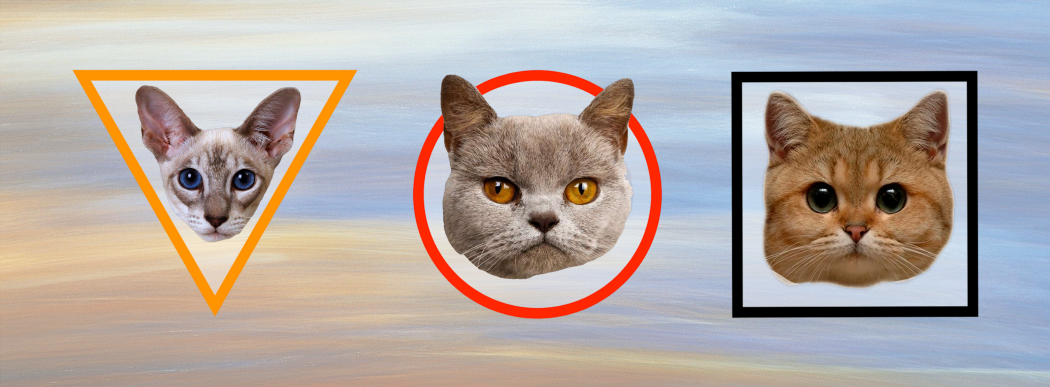

In [165]:
# check all category
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878650 entries, 2453577 to 1439613
Data columns (total 20 columns):
 #   Column            Dtype   
---  ------            -----   
 0   hour              category
 1   C1                category
 2   banner_pos        category
 3   site_id           category
 4   site_domain       category
 5   site_category     category
 6   device_id         category
 7   device_ip         category
 8   device_model      category
 9   device_type       category
 10  device_conn_type  category
 11  C14               category
 12  C15               category
 13  C16               category
 14  C17               category
 15  C18               category
 16  C19               category
 17  C20               category
 18  C21               category
 19  day_of_week       category
dtypes: category(20)
memory usage: 96.1 MB


In [ ]:
catboost = CatBoostClassifier(eval_metric="Logloss", loss_function = "Logloss", iterations=50)
catboost.fit(X_train, y_train, cat_features = np.append(np.arange(20), [23]))
# y_pred = catboost.predict(X_test)

In [ ]:
# # hyperparamter tuning
# opt = BayesSearchCV(
#     CatBoostClassifier(loss_function = "Logloss", iterations=10, task_type="GPU", cat_features=np.arange(20)),
#     {
#     'one_hot_max_size': Integer(2,255),
#     'max_depth': Integer(4,10),
#     'l2_leaf_reg': Real(1e-16, 1e5),
#     'random_strength': Real(0,100),
#     'border_count': (128, 254),
#     'bagging_temperature': Real(0.0, 1.0)
#     },
#     n_iter=10,
#     cv=3
# )

#opt.fit(X_train, y_train)
#opt.best_params_

In [170]:
# CV CatBoost
cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=np.append(np.arange(20), [23]))

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "Logloss",
          "eval_metric": "Logloss",
          "verbose": 10}

cv(cv_dataset, params, fold_count=5)

0:	learn: 0.6771580	test: 0.6770847	best: 0.6770847 (0)	total: 11.2s	remaining: 18m 27s
1:	learn: 0.6621993	test: 0.6620579	best: 0.6620579 (1)	total: 16.7s	remaining: 13m 39s
2:	learn: 0.6482107	test: 0.6480210	best: 0.6480210 (2)	total: 20.5s	remaining: 11m 3s
3:	learn: 0.6352098	test: 0.6349506	best: 0.6349506 (3)	total: 27.3s	remaining: 10m 54s
4:	learn: 0.6230781	test: 0.6227858	best: 0.6227858 (4)	total: 30s	remaining: 9m 29s
5:	learn: 0.6119109	test: 0.6115963	best: 0.6115963 (5)	total: 33.1s	remaining: 8m 37s
6:	learn: 0.6015114	test: 0.6012033	best: 0.6012033 (6)	total: 35.7s	remaining: 7m 54s
7:	learn: 0.5917805	test: 0.5914516	best: 0.5914516 (7)	total: 38.8s	remaining: 7m 25s
8:	learn: 0.5831159	test: 0.5827693	best: 0.5827693 (8)	total: 42.2s	remaining: 7m 6s
9:	learn: 0.5749146	test: 0.5745487	best: 0.5745487 (9)	total: 45.2s	remaining: 6m 47s
10:	learn: 0.5671259	test: 0.5667247	best: 0.5667247 (10)	total: 48.7s	remaining: 6m 34s
11:	learn: 0.5602497	test: 0.5598227	best

93:	learn: 0.4509650	test: 0.4479481	best: 0.4479481 (93)	total: 4m 31s	remaining: 17.3s
94:	learn: 0.4508038	test: 0.4477459	best: 0.4477459 (94)	total: 4m 33s	remaining: 14.4s
95:	learn: 0.4506792	test: 0.4475633	best: 0.4475633 (95)	total: 4m 36s	remaining: 11.5s
96:	learn: 0.4505232	test: 0.4473588	best: 0.4473588 (96)	total: 4m 39s	remaining: 8.64s
97:	learn: 0.4503979	test: 0.4472085	best: 0.4472085 (97)	total: 4m 42s	remaining: 5.77s
98:	learn: 0.4502571	test: 0.4470197	best: 0.4470197 (98)	total: 4m 45s	remaining: 2.89s
99:	learn: 0.4500766	test: 0.4468012	best: 0.4468012 (99)	total: 4m 48s	remaining: 0us


,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.677085,0.000152,0.677158,0.000184
1,1,0.662058,0.000225,0.662199,0.000241
2,2,0.648021,0.000135,0.648211,0.000197
3,3,0.634951,0.000057,0.635210,0.000159
4,4,0.622786,0.000109,0.623078,0.000154
...,...,...,...,...,...
95,95,0.447563,0.000608,0.450679,0.000209
96,96,0.447359,0.000631,0.450523,0.000166
97,97,0.447209,0.000627,0.450398,0.000211
98,98,0.447020,0.000613,0.450257,0.000185


<h2> XGBoost

In [210]:
# convert object to integer for XGBoost
# https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff
df_xgb = df.copy()
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
df_xgb = convert_obj_to_int(df_xgb)

In [212]:
X = df_xgb.drop(["click"], axis=1)
y = df_xgb["click"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [188]:
eta = 0.1
max_depth = 5
subsample = 0.8
colsample_bytree = 0.8

params = {
    "objective": "binary:logistic",
    "booster" : "gbtree",
    "eval_metric": "logloss",
    "eta": eta,
    "max_depth": max_depth,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "silent": 1,
}
num_boost_round = 260
early_stopping_rounds = 20

msk = np.random.rand(len(X_train)) < 0.8
dtrain = xgb.DMatrix(X_train[msk], y_train[msk])
dvalid = xgb.DMatrix(X_train[~msk], y_train[~msk])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

XGBoost params. ETA: 0.1, MAX_DEPTH: 5, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8


KeyError: 'click'

<h2> Light GBM

In [ ]:
df_lgb = df.copy()
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
df_lgb = convert_obj_to_int(df_lgb)

In [ ]:
X = df_lgb.drop(["click"], axis=1)
y = df_lgb["click"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_train[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_train[~msk], reference=lgb_train)

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, # feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 25
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)